In [2]:
import torch
import torch.nn as nn

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

MEAN = [0.5071, 0.4867, 0.4408] #mean of CIFAR-100 of RGB
STD  = [0.2675, 0.2565, 0.2761] #std of CIFAR-100 of RGB

train_tf = transforms.Compose([
    transforms.RandomCrop(32,padding=4), #encounter slight displacement
    transforms.RandomHorizontalFlip(), #Mirror
    transforms.ToTensor(),
    transforms.Normalize(MEAN,STD),
    transforms.RandomErasing(p=0.25, scale=(0.02,0.2), ratio=(0.3,3.3), value='random'), #Cutout some figure with probablity = 0.25
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

data = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_tf)

n_val = int(0.1*len(data)) #validation data 10%

train_subset, val_subset = random_split(data,[len(data) - n_val, n_val])

train_base = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_tf)
val_base = datasets.CIFAR100(root='./data', train=True, download=True, transform=test_tf)

train_set = torch.utils.data.Subset(train_base, train_subset.indices)
val_set = torch.utils.data.Subset(val_base, val_subset.indices)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set,   batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(datasets.CIFAR100(root='./data', train=False, download=True, transform=test_tf),
                          batch_size=128, shuffle=False, num_workers=4, pin_memory=True)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_c, out_c, stride = 1, downsample = None):
        #in_c : input channels
        #out_c : output channels
        expansion = 1
        super().__init__()
        self.conv1 = nn.Conv2d(in_c,out_c, kernel_size=3,stride=stride,padding=1,bias=False) #3*3
        self.bn1   = nn.BatchNorm2d(out_c)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_c,out_c, kernel_size=3, stride=1,padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_c)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample is not None:
            identity = self.downsample(identity)
        x = self.relu(x+identity)
        return x    


def make_layer_basic(in_c, out_c, blocks, first_stride):
    layers = []
    down = None
    if first_stride != 1 or in_c != out_c: #downsample or changing channels
        down = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=first_stride, bias=False),
            nn.BatchNorm2d(out_c),
        )
    layers.append(BasicBlock(in_c, out_c, stride=first_stride, downsample=down))
    for _ in range(1, blocks):
        layers.append(BasicBlock(out_c, out_c, stride=1))
    return nn.Sequential(*layers)

In [4]:
import torch
import torch.nn as nn
class ResNetCIFAR(nn.Module):
    def __init__(self, num_classes=100, drop_out = 0.1):
        super().__init__()
        # conv1：3×3,32,s=1,p=1 + BN + ReLU + Dropout
        self.stem = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(drop_out),
        )
        # conv2_x: ×2
        self.layer2 = make_layer_basic(in_c=32,  out_c=32,  blocks=2, first_stride=1)
        # conv3_x: ×4, stride=2
        self.layer3 = make_layer_basic(in_c=32,  out_c=64,  blocks=4, first_stride=2)
        # conv4_x: ×4, stride=2
        self.layer4 = make_layer_basic(in_c=64,  out_c=128, blocks=4, first_stride=2)
        # conv5_x: ×2, stride=2
        self.layer5 = make_layer_basic(in_c=128, out_c=256, blocks=2, first_stride=2)

        self.pool = nn.AdaptiveMaxPool2d(1)
        self.fc   = nn.Linear(256, num_classes)

    def forward(self, x, return_feats=False):
        feats = {}
        x = self.stem(x);   feats['conv1']   = x
        x = self.layer2(x); feats['conv2_x'] = x
        x = self.layer3(x); feats['conv3_x'] = x
        x = self.layer4(x); feats['conv4_x'] = x
        x = self.layer5(x); feats['conv5_x'] = x
        x = self.pool(x).flatten(1)          # N×256
        logits = self.fc(x)                  # N×100
        return (logits, feats) if return_feats else logits   

In [5]:

def evaluate_top1(model, loader, loss_fun, device):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)               
        loss = loss_fun(logits, y)
        b = y.size(0)
        loss_sum += loss.item() * b
        correct += (logits.argmax(1) == y).sum().item()
        total += b
    avg_loss = loss_sum / total
    top1_acc = 100.0 * correct / total
    return avg_loss, top1_acc


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetCIFAR(num_classes=100, drop_out=0.1).to(device) 

loss_fun = nn.CrossEntropyLoss()

num_epochs = 200
#lr=0.2 
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9, weight_decay=5e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

accuracy_train_list, accuracy_val_list = [], []
loss_train_list, loss_val_list = [], []

for epoch in range(num_epochs):
    # ---------- train ----------
    model.train() 
    running_loss,correct, total = 0.0, 0, 0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)          

        optimizer.zero_grad()
        logits = model(x_batch)       
        loss = loss_fun(logits, y_batch)       

        loss.backward()
        optimizer.step()

        b = y_batch.size(0)
        running_loss += loss.item() * b
        pred = logits.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total += b

    train_loss = running_loss / total
    train_acc  = 100.0 * correct / total



    # ---------- val ----------
    model.eval()
    running_loss_val,correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for x_val, y_val in val_loader:  
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            out = model(x_val)
            loss_t = loss_fun(out, y_val)

            b = y_val.size(0)
            running_loss_val += loss_t.item() * b
            pred_val = out.argmax(dim=1)
            correct_val += (pred_val== y_val).sum().item()
            total_val += b

    val_loss = running_loss_val / total_val
    val_acc  = 100.0 * correct_val / total_val

    loss_train_list.append(train_loss)
    loss_val_list.append(val_loss)
    accuracy_train_list.append(train_acc)
    accuracy_val_list.append(val_acc)

    scheduler.step() 
    print(f"lr = {optimizer.param_groups[0]['lr']:.6f}")
    print(f"Epoch {epoch+1:02d}/{num_epochs} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.2f}%  |  "
          f"val_loss={val_loss:.4f} acc={val_acc:.2f}%")
    


print("Training Complete")



lr = 0.199988
Epoch 01/200 | train_loss=4.8278 acc=1.41%  |  val_loss=4.4535 acc=2.44%
lr = 0.199951
Epoch 02/200 | train_loss=4.3766 acc=2.56%  |  val_loss=4.3500 acc=2.84%
lr = 0.199889
Epoch 03/200 | train_loss=4.1931 acc=4.48%  |  val_loss=4.0953 acc=5.26%
lr = 0.199803
Epoch 04/200 | train_loss=4.0233 acc=6.79%  |  val_loss=3.9528 acc=8.54%
lr = 0.199692
Epoch 05/200 | train_loss=3.8679 acc=9.37%  |  val_loss=3.8571 acc=9.26%
lr = 0.199556
Epoch 06/200 | train_loss=3.7290 acc=11.79%  |  val_loss=3.7840 acc=11.28%
lr = 0.199396
Epoch 07/200 | train_loss=3.6421 acc=13.37%  |  val_loss=3.6932 acc=13.58%
lr = 0.199212
Epoch 08/200 | train_loss=3.5256 acc=15.70%  |  val_loss=3.4595 acc=15.84%
lr = 0.199002
Epoch 09/200 | train_loss=3.4116 acc=17.58%  |  val_loss=3.6273 acc=15.56%
lr = 0.198769
Epoch 10/200 | train_loss=3.3193 acc=19.24%  |  val_loss=3.3193 acc=19.32%
lr = 0.198511
Epoch 11/200 | train_loss=3.1927 acc=21.38%  |  val_loss=3.2369 acc=20.08%
lr = 0.198229
Epoch 12/200 | tr

In [8]:
test_loss, test_top1 = evaluate_top1(model, test_loader, loss_fun, device)
print(f"[TEST] loss={test_loss:.4f}  top1_acc={test_top1:.2f}%")

[TEST] loss=1.1656  top1_acc=73.07%


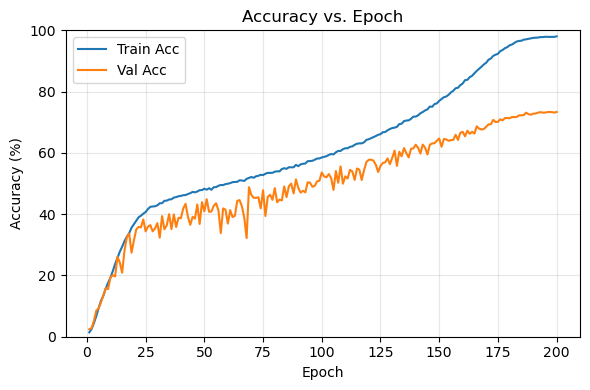

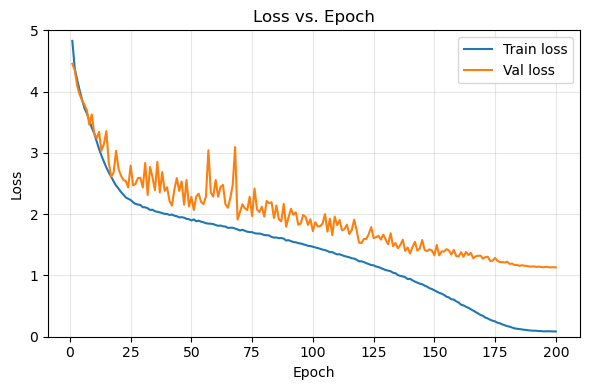

In [11]:
#drop_out = 0.1 , lr = 0.2 with scheduler, momentum=0.9, weight_decay=5e-4，

import os
import matplotlib.pyplot as plt
import numpy as np

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

epochs = np.arange(1, len(accuracy_train_list)+1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy_train_list, label='Train Acc')
plt.plot(epochs, accuracy_val_list,   label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epoch')
plt.ylim(0, 100)     
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss_train_list, label='Train loss')
plt.plot(epochs, loss_val_list,   label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.ylim(0, 5)     
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetCIFAR(num_classes=100, drop_out=0.1).to(device) 
loss_fun = nn.CrossEntropyLoss(label_smoothing=0.1)

#lr=0.01
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
#scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

num_epochs = 50

accuracy_train_list2, accuracy_val_list2 = [], []
loss_train_list2, loss_val_list2 = [], []

for epoch in range(num_epochs):
    # ---------- train ----------
    model.train() 
    running_loss,correct, total = 0.0, 0, 0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)          

        optimizer.zero_grad()
        logits = model(x_batch)       
        loss = loss_fun(logits, y_batch)       

        loss.backward()
        optimizer.step()

        b = y_batch.size(0)
        running_loss += loss.item() * b
        pred = logits.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total += b

    train_loss = running_loss / total
    train_acc  = 100.0 * correct / total



    # ---------- val ----------
    model.eval()
    running_loss_val,correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for x_val, y_val in val_loader:  
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            out = model(x_val)
            loss_t = loss_fun(out, y_val)

            b = y_val.size(0)
            running_loss_val += loss_t.item() * b
            pred_val = out.argmax(dim=1)
            correct_val += (pred_val== y_val).sum().item()
            total_val += b

    val_loss = running_loss_val / total_val
    val_acc  = 100.0 * correct_val / total_val

    loss_train_list2.append(train_loss)
    loss_val_list2.append(val_loss)
    accuracy_train_list2.append(train_acc)
    accuracy_val_list2.append(val_acc)

    #scheduler.step() 
    #print(f"lr = {optimizer.param_groups[0]['lr']:.6f}")

    print(f"Epoch {epoch+1:02d}/{num_epochs} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.2f}%  |  "
          f"val_loss={val_loss:.4f} acc={val_acc:.2f}%")

print("Training Complete")


test_loss, test_top1 = evaluate_top1(model, test_loader, loss_fun, device)
print(f"[TEST] loss={test_loss:.4f}  top1_acc={test_top1:.2f}%")



Epoch 01/50 | train_loss=4.4485 acc=5.04%  |  val_loss=4.1888 acc=9.02%
Epoch 02/50 | train_loss=3.9203 acc=12.48%  |  val_loss=3.8498 acc=15.04%
Epoch 03/50 | train_loss=3.6397 acc=18.55%  |  val_loss=3.5107 acc=20.54%
Epoch 04/50 | train_loss=3.4086 acc=23.56%  |  val_loss=3.3571 acc=24.94%
Epoch 05/50 | train_loss=3.2173 acc=28.29%  |  val_loss=3.2036 acc=29.48%
Epoch 06/50 | train_loss=3.0188 acc=33.42%  |  val_loss=2.9866 acc=33.98%
Epoch 07/50 | train_loss=2.8440 acc=37.43%  |  val_loss=2.8553 acc=37.96%
Epoch 08/50 | train_loss=2.6938 acc=41.38%  |  val_loss=2.9642 acc=40.08%
Epoch 09/50 | train_loss=2.5733 acc=45.02%  |  val_loss=2.6129 acc=44.38%
Epoch 10/50 | train_loss=2.4626 acc=48.10%  |  val_loss=2.5618 acc=45.46%
Epoch 11/50 | train_loss=2.3733 acc=50.22%  |  val_loss=2.3873 acc=49.80%
Epoch 12/50 | train_loss=2.2973 acc=52.81%  |  val_loss=2.4166 acc=49.84%
Epoch 13/50 | train_loss=2.2175 acc=55.14%  |  val_loss=2.4618 acc=48.84%
Epoch 14/50 | train_loss=2.1592 acc=57.0

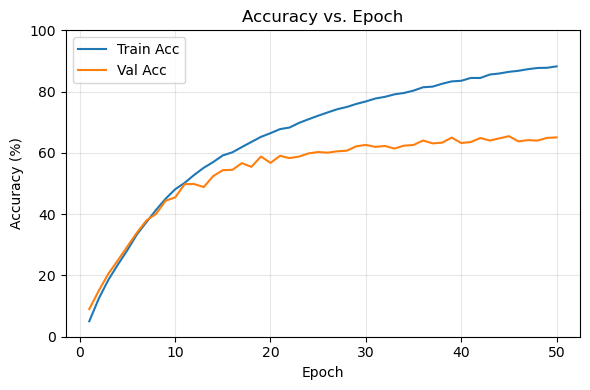

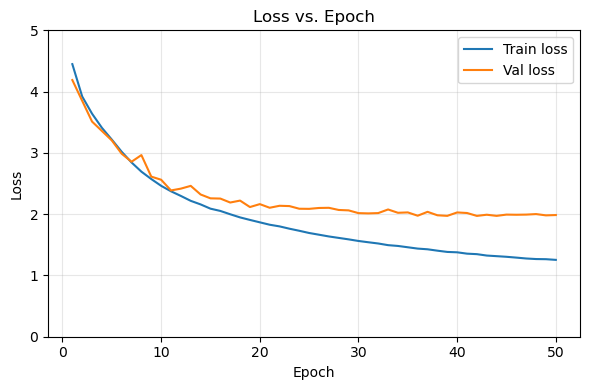

In [14]:
#drop_out = 0.1 , lr = 0.01, momentum=0.9, weight_decay=5e-4，

import os
import matplotlib.pyplot as plt
import numpy as np

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

epochs = np.arange(1, len(accuracy_train_list2)+1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy_train_list2, label='Train Acc')
plt.plot(epochs, accuracy_val_list2,   label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epoch')
plt.ylim(0, 100)     
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss_train_list2, label='Train loss')
plt.plot(epochs, loss_val_list2, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.ylim(0, 5)     
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetCIFAR(num_classes=100, drop_out=0.1).to(device) 
loss_fun = nn.CrossEntropyLoss(label_smoothing=0.1)

#lr=0.001 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

num_epochs = 50

accuracy_train_list3, accuracy_val_list3 = [], []
loss_train_list3, loss_val_list3 = [], []

for epoch in range(num_epochs):
    # ---------- train ----------
    model.train() 
    running_loss,correct, total = 0.0, 0, 0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)          

        optimizer.zero_grad()
        logits = model(x_batch)       
        loss = loss_fun(logits, y_batch)       

        loss.backward()
        optimizer.step()

        b = y_batch.size(0)
        running_loss += loss.item() * b
        pred = logits.argmax(dim=1)
        correct += (pred == y_batch).sum().item()
        total += b

    train_loss = running_loss / total
    train_acc  = 100.0 * correct / total



    # ---------- val ----------
    model.eval()
    running_loss_val,correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for x_val, y_val in val_loader:  
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            out = model(x_val)
            loss_t = loss_fun(out, y_val)

            b = y_val.size(0)
            running_loss_val += loss_t.item() * b
            pred_val = out.argmax(dim=1)
            correct_val += (pred_val== y_val).sum().item()
            total_val += b

    val_loss = running_loss_val / total_val
    val_acc  = 100.0 * correct_val / total_val

    loss_train_list3.append(train_loss)
    loss_val_list3.append(val_loss)
    accuracy_train_list3.append(train_acc)
    accuracy_val_list3.append(val_acc)

    print(f"Epoch {epoch+1:02d}/{num_epochs} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.2f}%  |  "
          f"val_loss={val_loss:.4f} acc={val_acc:.2f}%")

print("Training Complete")

test_loss, test_top1 = evaluate_top1(model, test_loader, loss_fun, device)
print(f"[TEST] loss={test_loss:.4f}  top1_acc={test_top1:.2f}%")

Epoch 01/50 | train_loss=4.4149 acc=5.25%  |  val_loss=4.0984 acc=9.30%
Epoch 02/50 | train_loss=3.9754 acc=11.72%  |  val_loss=3.8943 acc=13.40%
Epoch 03/50 | train_loss=3.7849 acc=15.59%  |  val_loss=3.7302 acc=16.74%
Epoch 04/50 | train_loss=3.6302 acc=18.72%  |  val_loss=3.5694 acc=19.86%
Epoch 05/50 | train_loss=3.4881 acc=21.94%  |  val_loss=3.4569 acc=22.14%
Epoch 06/50 | train_loss=3.3687 acc=24.81%  |  val_loss=3.3336 acc=26.14%
Epoch 07/50 | train_loss=3.2626 acc=27.06%  |  val_loss=3.2310 acc=27.84%
Epoch 08/50 | train_loss=3.1534 acc=29.96%  |  val_loss=3.1416 acc=29.40%
Epoch 09/50 | train_loss=3.0722 acc=31.86%  |  val_loss=3.0685 acc=32.48%
Epoch 10/50 | train_loss=2.9840 acc=34.48%  |  val_loss=3.0440 acc=33.24%
Epoch 11/50 | train_loss=2.9058 acc=35.94%  |  val_loss=2.9761 acc=34.18%
Epoch 12/50 | train_loss=2.8257 acc=38.29%  |  val_loss=2.8824 acc=36.38%
Epoch 13/50 | train_loss=2.7602 acc=39.93%  |  val_loss=2.8533 acc=37.68%
Epoch 14/50 | train_loss=2.6887 acc=41.8

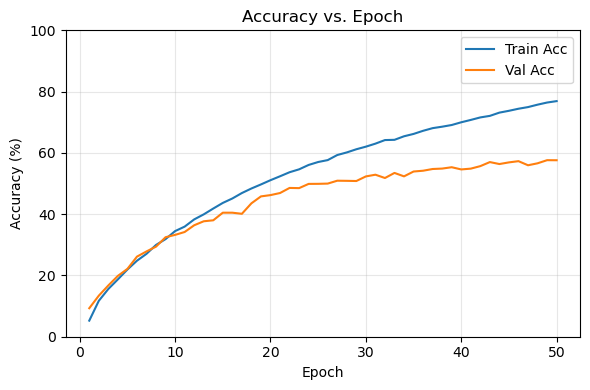

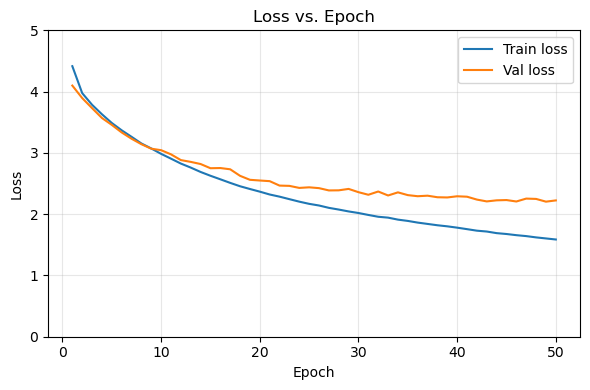

In [ ]:
#drop_out = 0.1 , lr = 0.001, momentum=0.9, weight_decay=5e-4，

import os
import matplotlib.pyplot as plt
import numpy as np

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

epochs = np.arange(1, len(accuracy_train_list3)+1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy_train_list3, label='Train Acc')
plt.plot(epochs, accuracy_val_list3,   label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epoch')
plt.ylim(0, 100)     
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss_train_list3, label='Train loss')
plt.plot(epochs, loss_val_list3, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.ylim(0, 5)     
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

3. output sizes for each convX layer.

conv1 : (32,32,32)

conv2 : (32,32,32)

conv3 : (64,16,16)

conv4 : (128,8,8)

conv5 : (256,4,4)
